In [ ]:
# Imports
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import yfinance as yf
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas_datareader.data as web

In [ ]:
'''d1 = pd.read_excel(io.BytesIO(uploaded['EPS_fwd.xlsx']), index_col=0,
                   parse_dates=True)
d2 = pd.read_excel(io.BytesIO(uploaded['PCR.xlsx']), index_col=0,
                   parse_dates=True)
d3 = pd.read_excel(io.BytesIO(uploaded['nasdaq_100.xlsx']), index_col=0,
                   parse_dates=True)
d4 = pd.read_excel(io.BytesIO(uploaded['Vix_weekly.xlsx']), index_col=0,
                   parse_dates=True)
d5 = pd.read_excel(io.BytesIO(uploaded['price.xlsx']), index_col=0,
                   parse_dates=True)

'''
d1 = pd.read_excel('EPS_fwd.xlsx', index_col=0,
                   parse_dates=True)
d2 = pd.read_excel('PCR.xlsx', index_col=0,
                   parse_dates=True)
d3 = pd.read_excel('nasdaq_100.xlsx', index_col=0,
                   parse_dates=True)
d4 = pd.read_excel('Vix_weekly.xlsx', index_col=0,
                   parse_dates=True)
d5 = pd.read_excel('price.xlsx',
                   parse_dates=True)


d1.reset_index(inplace=True)
d2.reset_index(inplace=True)
d3.reset_index(inplace=True)
d4.reset_index(inplace=True)
d5.reset_index(inplace=True)

In [ ]:
data = d1.merge(d2, on="Date", how="inner")\
         .merge(d3, on="Date", how="inner")\
         .merge(d4, on="Date", how="inner")\
         .merge(d5, on="Date", how="inner")

In [ ]:
data = data.rename(columns=lambda x: x.strip())
data = data.rename(columns={
    'MSFT US Equity - BEst EPS': 'eps',
    'MSFT US Equity - Put Call Volume Ratio - Current Day': 'pcr',
    'NDX Index - Last Price': 'ndx',
    'Last Price_x': 'vix',
    'Last Price_y': 'price'})
data
data.index = data['Date']



In [ ]:
data.set_index('Date', inplace=True)

In [ ]:
# Split into training and testing with the last 7 years as test data
end_date = data.index.max()
split_date = end_date - pd.DateOffset(years=7)  # Subtract 7 years

train_df = data[data.index <= split_date]
test_df = data[data.index > split_date]

# Display dataset ranges
print(f"\nTrain set: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} observations)")
print(f"Test set: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} observations)")



Train set: 2000-01-07 00:00:00 to 2018-02-16 00:00:00 (946 observations)
Test set: 2018-02-23 00:00:00 to 2025-02-21 00:00:00 (366 observations)


### Kalman Filter Functon :

- The Kalman filter is a state-space model, meaning it estimates a hidden (unobserved) state $x_t$ over time, where $x_t$ represents the forecasted MSFT stock price or the true fundamental value. The goal is to filter out the noise component in MSFT stock price

- The parameter a controls how much of the previous fundamental estimate $x_{t-1}$ carries over into the next period $x_t$, hence the name "state transition coefficient". A value close to 1 suggests a random walk where old information has more influence over the future stock price, whereas a value close to 0 implies the fundamental factors (EPS), market sentiment (VIX, PCR) and sector trends (NASDAQ100) exhibit more influence

- The parameter k represents "the gain" which acts as a weight placed on the current data. The value of k represent how much we think the market cares about current data versus the past information. A k value close to 0 suggests forecasting the stock price mainly based on past information, whereas a k value approaching 1 implies new information influences the forecasted price of MSFT

- The betas are initialized from running a regression germane to the fundamental factors (EPS), market sentiment (VIX, PCR) and sector trends (NASDAQ100) and normalizing the raw values. These weights act as the relative controlling influence over MSFT stock  

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
# Kalman Filter


def kalman_filter(df, q):

    scaled_features = scaler.fit_transform(df[['eps', 'pcr', 'ndx', 'vix']])  # Standardize

    features = pd.DataFrame(scaled_features, columns=['eps', 'pcr', 'ndx', 'vix'], index = df.index)
    #features = pd.DataFrame(scaled_features, columns=['eps', 'pcr', 'ndx', 'vix'])
    prediction = []
    num_features = 4

    # Ensure lengths match
    features = features.iloc[:len(train_df['price'])]#.reset_index(drop=True)

    X = np.zeros(num_features + 1)  # Initial State
    P = np.eye(num_features + 1)     # Initial Cov Matrix
    Q = np.eye(num_features + 1) * q  # Process Noise Cov
    R = 10 # Can think about if we want to optimize this too


    for t in range(len(features)):
        z = np.array(features.iloc[t])
        z = np.insert(z, 0, 1)

        # Prediction Step
        X_prior = X.copy()

        P_prior = P + Q

        # Kalman Gain Computation
        H = z.reshape(1,-1)

        S = (H @ P_prior @ H.T).item() + R

        K = (P_prior @ z.T)/S

        # Update Step
        y_t = train_df['price'].iloc[t]
        X = X_prior + K * (y_t - z @ X_prior)

        P = (np.eye(num_features + 1) - np.outer(K, z)) @ P_prior  # Covariance update

        # Store prediction
        predicted_price = z @ X
        prediction.append(predicted_price)

    return prediction



In [ ]:
train_df['Kalman_State_Pred'] = kalman_filter(train_df,0.04)

<ipython-input-13-430a2a4610a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Kalman_State_Pred'] = kalman_filter(train_df,0.04)


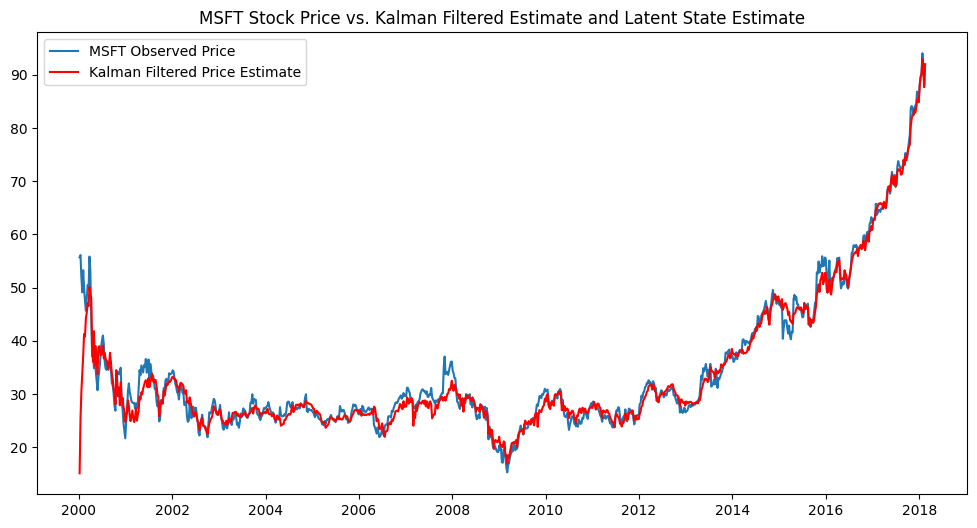

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df["price"], label="MSFT Observed Price")
plt.plot(train_df.index, train_df["Kalman_State_Pred"], label="Kalman Filtered Price Estimate", color="red")
plt.legend()
plt.title("MSFT Stock Price vs. Kalman Filtered Estimate and Latent State Estimate")
plt.show()

In [ ]:
### Add pcr and the change in the vix to dataframe
train_df = train_df.copy(deep = True)
train_df["pcr"] = train_df["pcr"]
train_df["vix_diff"] =train_df["vix"].diff()
train_df= train_df.dropna()
train_df

,eps,pcr,ndx,vix,index,price,Kalman_State_Pred,vix_diff
Date,,,,,,,,
2000-01-14,0.895,0.2722,3704.74,19.66,16,56.1250,25.376699,-2.06
2000-01-21,0.904,0.4563,3849.96,20.82,17,51.8750,30.568677,1.16
2000-01-28,0.905,0.3180,3446.13,26.14,18,49.1250,33.817052,5.32
2000-02-04,0.908,0.4418,3874.37,21.54,19,53.2812,37.290637,-4.60
2000-02-11,0.910,0.2787,3968.89,24.42,20,49.9688,41.292847,2.88
...,...,...,...,...,...,...,...,...
2018-01-19,3.617,0.4252,6834.33,11.27,956,90.0000,90.279384,1.11
2018-01-26,3.631,0.3557,7022.97,11.08,957,94.0600,92.960609,-0.19
2018-02-02,3.801,0.4725,6760.29,17.31,958,91.7800,91.360680,6.23


In [ ]:
### Add pcr and the change in the vix to test dataframe
test_df = test_df.copy(deep = True)
test_df["pcr"] = test_df["pcr"]
test_df ["vix_diff"] = test_df["vix"].diff()
test_df = test_df.dropna()
test_df

,eps,pcr,ndx,vix,index,price,vix_diff
Date,,,,,,,
2018-03-02,3.841,0.5570,6811.04,19.59,962,93.05,3.10
2018-03-09,3.842,0.3289,7101.18,14.64,963,96.54,-4.95
2018-03-16,3.844,0.5096,7019.95,15.80,964,94.60,1.16
2018-03-23,3.854,0.5392,6508.09,24.87,965,87.18,9.07
2018-03-30,3.858,0.5291,6581.13,19.97,966,91.27,-4.90
...,...,...,...,...,...,...,...
2025-01-24,14.265,0.7023,21774.01,14.85,1322,444.06,-1.12
2025-01-31,14.366,0.4072,21478.05,16.43,1323,415.06,1.58
2025-02-07,14.408,0.4306,21491.31,16.54,1324,409.75,0.11


In [ ]:
def trading_strategy(q, df, hp, alpha=0.1, z=0.103):
    df = df.copy()

    df['Kalman_State_Pred'] = kalman_filter(df, q)

    # Compute filter standard deviation
    df['Kalman_State_Std'] = df['Kalman_State_Pred'].ewm(alpha=alpha).std().fillna(0)

    # Create trading thresholds
    df['Upper_Threshold'] = df['Kalman_State_Pred'] + (z * df['Kalman_State_Std'])
    df['Lower_Threshold'] = df['Kalman_State_Pred'] - (z * df['Kalman_State_Std'])

    # Defining long and short conditions
    short_condition = (df['price'] > df['Upper_Threshold']) & (df['pcr'] > 0.7) & (df['vix_diff'] > 0)
    long_condition = (df['price'] < df['Lower_Threshold']) & (df['pcr'] < 0.7) & (df['vix_diff'] < 0)

    df['Signal'] = np.nan
    df.loc[long_condition, 'Signal'] = 1
    df.loc[short_condition, 'Signal'] = -1

    # Forward-fill signals up the n holding periods
    # This prevents outdated signals from propagating beyond the holding period
    # Remaining NA values are set to 0, ensuring no trade occurs unless a valid signal appears
    df['Signal'] = df['Signal'].ffill(limit=int(hp)).fillna(0)

    # Compute log returns & fill NA
    df['Log_Return'] = np.log(df['price']) - np.log(df['price'].shift(1))
    df['Log_Return'] = df['Log_Return'].fillna(0)

    # Compute strategy returns
    df['Strategy_Return'] = df['Signal'].shift() * df['Log_Return']

    # Compute strategy cumulative returns
    df['Strategy_Cumulative_Return'] = np.exp(df['Strategy_Return'].cumsum()) - 1

    # Compute actual returns and cumulative returns
    df['Actual_Return'] = df['price'].pct_change()
    df['Actual_Cumulative_Return'] = (1 + df['Actual_Return']).cumprod()

    return df


In [ ]:
df_test = trading_strategy(0.04, train_df, hp=10)
print(df_test.head())  # Verify Signal & Returns


              eps     pcr      ndx    vix  index    price  Kalman_State_Pred  \
Date                                                                           
2000-01-14  0.895  0.2722  3704.74  19.66     16  56.1250          16.349564   
2000-01-21  0.904  0.4563  3849.96  20.82     17  51.8750          24.404580   
2000-01-28  0.905  0.3180  3446.13  26.14     18  49.1250          29.298228   
2000-02-04  0.908  0.4418  3874.37  21.54     19  53.2812          33.795715   
2000-02-11  0.910  0.2787  3968.89  24.42     20  49.9688          38.464294   

            vix_diff  Kalman_State_Std  Upper_Threshold  Lower_Threshold  \
Date                                                                       
2000-01-14     -2.06          0.000000        16.349564        16.349564   
2000-01-21      1.16          5.695757        24.991243        23.817917   
2000-01-28      5.32          6.477386        29.965399        28.631058   
2000-02-04     -4.60          7.352535        34.553026    

In [ ]:
strategy1 = trading_strategy(0.04, train_df, alpha = 0.1, z=0.1, hp=86)
strategy1 = strategy1.dropna()
strategy1

,eps,pcr,ndx,vix,index,price,Kalman_State_Pred,vix_diff,Kalman_State_Std,Upper_Threshold,Lower_Threshold,Signal,Log_Return,Strategy_Return,Strategy_Cumulative_Return,Actual_Return,Actual_Cumulative_Return
Date,,,,,,,,,,,,,,,,,
2000-01-21,0.904,0.4563,3849.96,20.82,17,51.8750,24.404580,1.16,5.695757,24.974156,23.835005,0.0,-0.078744,-0.000000,0.000000,-0.075724,0.924276
2000-01-28,0.905,0.3180,3446.13,26.14,18,49.1250,29.298228,5.32,6.477386,29.945967,28.650490,0.0,-0.054469,-0.000000,0.000000,-0.053012,0.875278
2000-02-04,0.908,0.4418,3874.37,21.54,19,53.2812,33.795715,-4.60,7.352535,34.530969,33.060461,0.0,0.081215,0.000000,0.000000,0.084605,0.949331
2000-02-11,0.910,0.2787,3968.89,24.42,20,49.9688,38.464294,2.88,8.390466,39.303341,37.625248,0.0,-0.064185,-0.000000,0.000000,-0.062168,0.890313
2000-02-18,0.913,0.6802,3965.75,26.00,21,47.5312,38.543441,1.58,8.336726,39.377113,37.709768,0.0,-0.050012,-0.000000,0.000000,-0.048782,0.846881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-19,3.617,0.4252,6834.33,11.27,956,90.0000,90.280358,1.11,6.556386,90.935997,89.624720,-1.0,0.004454,-0.004454,6.645296,0.004464,1.603563
2018-01-26,3.631,0.3557,7022.97,11.08,957,94.0600,92.961734,-0.19,7.008047,93.662539,92.260930,-1.0,0.044123,-0.044123,6.315295,0.045111,1.675902
2018-02-02,3.801,0.4725,6760.29,17.31,958,91.7800,91.360879,6.23,7.072596,92.068139,90.653619,-1.0,-0.024538,0.024538,6.497021,-0.024240,1.635278


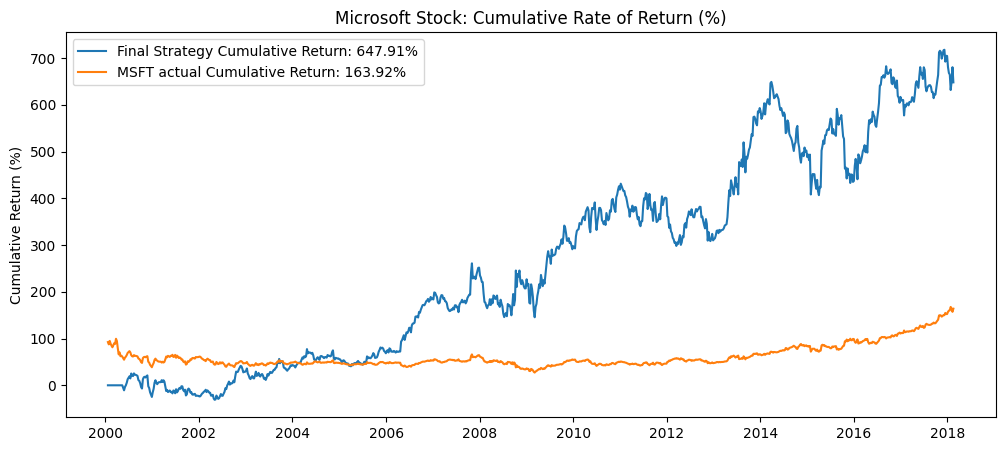

In [ ]:
# Plot the cumulative rate of return for the strategy
# Unoptimized Strategy
scr = strategy1['Strategy_Cumulative_Return'].iloc[-1]*100
acr = strategy1['Actual_Cumulative_Return'].iloc[-1]*100
plt.figure(figsize=(12,5))
plt.plot(strategy1['Strategy_Cumulative_Return'] * 100, label=f'Final Strategy Cumulative Return: {scr:.2f}%')
plt.plot(strategy1['Actual_Cumulative_Return'] * 100, label=f'MSFT actual Cumulative Return: {acr:.2f}%')
plt.ylabel('Cumulative Return (%)')
plt.title('Microsoft Stock: Cumulative Rate of Return (%)')
plt.legend()
plt.show()

In [ ]:
strategy = strategy1.copy()

In [ ]:
# Using new kalman filter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define parameter grids
q_values = np.linspace(0, 0.2, 10)  # Step of 0.02
hp_values = np.arange(1, 100, 1)

#q_values = [0.01, 0.1, 0.5]
#hp_values = [3,5,7]

# Initialize results matrix
results = np.zeros((len(q_values), len(hp_values)))

# Iterate over parameter combinations
for i, q in enumerate(q_values):
    for j, hp in enumerate(hp_values):
        #print(f"Processing q={k_t:.2f}, hp={hp}...")  # Debug print
        # Apply the filter to MSFT stock prices


        # Create DataFrame
        df_filtered = pd.DataFrame({
              "price": train_df['price'],


             })

        ### Add pcr and the change in the vix to dataframe
        df_filtered["eps"] = train_df["eps"]
        df_filtered["pcr"] = train_df["pcr"]
        df_filtered["ndx"] = train_df["ndx"]
        df_filtered["vix"] = train_df["vix"]
        df_filtered["vix_diff"] = train_df["vix"].diff()
        df_filtered = df_filtered .dropna()

        strategy1 = trading_strategy(q, df_filtered,int(hp), alpha = 0.1, z=0.1)

        df_heatmap = train_df.merge(strategy1, how="inner", on = "price")
        df_heatmap.dropna(inplace=True)
        #df_heatmap.drop(columns=['Date'], inplace=True) # index not in my df
        #df_heatmap.drop(columns=['Date','index'], inplace=True)



        # Extract final strategy return
        if 'Strategy_Cumulative_Return' in df_heatmap.columns:
            final_return = df_heatmap['Strategy_Cumulative_Return'].iloc[-1]
            print(f"Final Return for q={q:.2f}, hp={hp}: {final_return}")  # Debug print
            results[i, j] = final_return
        else:
            print(f"WARNING: Column 'Strategy_Cumulative_Return' missing for q={q:.2f}, hp={hp}")
            results[i, j] = np.nan

# ** Debugging final results **
print("\nFinal Results Matrix:\n", results)

# ** Plot Heatmap **
fig_width = max(12, len(hp_values) / 10)
fig_height = max(8, len(q_values) / 5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(results, annot=False, cmap="YlGnBu")
plt.xlabel("hp (Holding Period)")
plt.ylabel("q (Kalman Gain)")
plt.title("Optimization Heatmap for q and hp")
plt.show()

In [ ]:
from itertools import product
def walk_forward(df, w):

    # Add Kalman values and VIX difference to dataframe
    #df = data.copy()
    df = df.copy(deep = True)
    #df = df.loc[train_df.index] #Ensure df has the same index as train_df for alignment
    #df['Kalman_State_Pred'] = kalman_filter(0.04)
    df["vix_diff"] = df["vix"].diff()
    df= df.dropna()

    # Edited range to speed up compute time
    q_values = np.linspace(0, 0.2, 10)
    hp_values = np.arange(1, 100, 5)

    final_results = []

    # Each iteration moves the rolling window forward by one week
    for i in range(w, len(df)):

        # Define training df to be of length w-weeks
        # We will move forward by w-weeks
        data_train = df.iloc[i-w:i].copy()

        # Store performance of all (Q, HP) combinations within each rolling window
        hparam_results = []

        # Loop through all (Q, HP) combinations to optimize hyperparameters
        for q, hp in product(q_values, hp_values):

            # Training Model : Generate trading strategy on training data to find
            # best hyperparameters to apply on out of sample data
            train_strategy = trading_strategy(q, data_train, hp, alpha=0.1, z=0.1)

            # Extract the final cumulative return for given (Q, HP) combination
            final_return = train_strategy["Strategy_Cumulative_Return"].iloc[-1]

            # Append the evaluated (Q, HP) combination and its final return
            hparam_results .append({"Q": q, "HP": hp, "Strategy_Return": final_return})

        # Store the best (Q, HP) combination by highest Strategy Return
        hparam_best = pd.DataFrame(hparam_results).sort_values(by="Strategy_Return", ascending=False).iloc[0]

        q, hp = hparam_best["Q"], hparam_best["HP"]

        # Apply the best hyperparameters to evaluate the model on the next unseen test period
        # Select only row i as a DataFrame
        #test_week = min(i, len(df) - 1)
        test_week_1 = min(i, len(df) - 1)
        data_test = df.iloc[test_week_1:test_week_1 + 20].copy()
        test_strategy = trading_strategy(q, data_test, hp, alpha=0.1, z=0.103)

        # Ensure best Q and HP are included in the results
        test_strategy["Q"] = q
        test_strategy["HP"] = hp

        # Store best Q and HP along with final test period return
        best_row = {
            "Q": q,
            "HP": hp,
            "Strategy_Return": test_strategy["Strategy_Cumulative_Return"].iloc[-1]
        }
        final_results.append(best_row)

        print(i) #debugging check

    return pd.DataFrame(final_results)

In [ ]:
# Testing on 24 weeks for rolling window to speed up compute
test = walk_forward(train_df, w=24)

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292


In [ ]:
# Drop Na
test.dropna(inplace = True)

In [ ]:
final_params_df = test.copy(deep = True)

In [ ]:
final_params_df['Strategy_Return']

,Strategy_Return
0,0.074164
1,-0.051708
2,-0.013604
3,0.091678
4,-0.095622
...,...
913,-0.041522
914,-0.041522
915,-0.041522
916,-0.041522


In [ ]:
# Find the row with the maximum value in the specified column
optimized_values = final_params_df[final_params_df['Strategy_Return'] == final_params_df['Strategy_Return'].max()]

NameError: name 'final_params_df' is not defined

In [ ]:
optimized_values

In [ ]:
#strategy_final = trading_strategy(optimized_values['Q'].iloc[0], test_df, optimized_values['HP'].iloc[0], alpha = 0.1, z=0.1)
strategy_final = trading_strategy(0.066667, test_df, 1, alpha = 0.1, z=0.1)
strategy_final = strategy_final.dropna()
strategy_final

,eps,pcr,ndx,vix,index,price,vix_diff,Kalman_State_Pred,Kalman_State_Std,Upper_Threshold,Lower_Threshold,Signal,Log_Return,Strategy_Return,Strategy_Cumulative_Return,Actual_Return,Actual_Cumulative_Return
Date,,,,,,,,,,,,,,,,,
2018-03-09,3.842,0.3289,7101.18,14.64,963,96.54,-4.95,34.640508,10.153858,35.655894,33.625122,0.0,0.036820,0.0,0.000000,0.037507,1.037507
2018-03-16,3.844,0.5096,7019.95,15.80,964,94.60,1.16,34.253258,7.953745,35.048633,33.457884,0.0,-0.020300,-0.0,0.000000,-0.020095,1.016658
2018-03-23,3.854,0.5392,6508.09,24.87,965,87.18,9.07,38.104989,7.560148,38.861004,37.348974,0.0,-0.081683,-0.0,0.000000,-0.078436,0.936916
2018-03-30,3.858,0.5291,6581.13,19.97,966,91.27,-4.90,40.715275,7.495522,41.464827,39.965723,0.0,0.045847,0.0,0.000000,0.046914,0.980870
2018-04-06,3.870,0.9041,6433.21,21.49,967,90.23,1.52,37.600804,6.663528,38.267157,36.934451,-1.0,-0.011460,-0.0,0.000000,-0.011395,0.969694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24,14.265,0.7023,21774.01,14.85,1322,444.06,-1.12,28.760789,1.833063,28.944095,28.577483,0.0,0.034433,0.0,-0.362272,0.035033,4.772273
2025-01-31,14.366,0.4072,21478.05,16.43,1323,415.06,1.58,29.443564,1.906253,29.634189,29.252939,0.0,-0.067537,-0.0,-0.362272,-0.065306,4.460613
2025-02-07,14.408,0.4306,21491.31,16.54,1324,409.75,0.11,29.445482,1.940388,29.639521,29.251443,0.0,-0.012876,-0.0,-0.362272,-0.012793,4.403546


Metrics

In [ ]:
sp500 = yf.download("^GSPC", start='2000-01-21', end= '2025-02-21')
sp500 = sp500[['Close']].rename(columns={'Close': 'SP500'})
rf = web.DataReader('DGS1', 'fred', '2000-01-21', '2025-02-21')
rf_monthly = ((rf.resample('M').last()/100)+1)**(1/12)-1

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-26-4aa5d9666cca>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rf_monthly = ((rf.resample('M').last()/100)+1)**(1/12)-1


In [ ]:
returns_m = pd.DataFrame()
returns_m['Strategy_Monthly'] = strategy_final['Strategy_Return'].resample('M').sum()
returns_m['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()
returns_m['rf'] = rf_monthly

<ipython-input-27-f707faca9a3e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m['Strategy_Monthly'] = strategy_final['Strategy_Return'].resample('M').sum()
<ipython-input-27-f707faca9a3e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()


In [ ]:
returns_m

,Strategy_Monthly,SP500_Monthly,rf,excess_return_strategy,excess_SP500
Date,,,,,
2018-03-31,0.000000,-0.025627,0.001725,-0.001725,-0.027352
2018-04-30,-0.051515,0.003901,0.001848,-0.053363,0.002053
2018-05-31,-0.020543,0.021838,0.001840,-0.022383,0.019999
2018-06-30,-0.024405,0.005143,0.001921,-0.026326,0.003221
2018-07-31,0.000000,0.035714,0.002011,-0.002011,0.033703
...,...,...,...,...,...
2024-10-31,0.000000,-0.009413,0.003491,-0.003491,-0.012903
2024-11-30,-0.031400,0.056346,0.003515,-0.034914,0.052832
2024-12-31,0.014000,-0.024477,0.003402,0.010598,-0.027880


In [ ]:
# get the excess return for both the benchmark and your returns
returns_m['excess_return_strategy'] = returns_m['Strategy_Monthly'] - returns_m['rf']
returns_m['excess_SP500'] = returns_m['SP500_Monthly'] - returns_m['rf']


In [ ]:
returns_m

,Strategy_Monthly,SP500_Monthly,rf,excess_return_strategy,excess_SP500
Date,,,,,
2018-03-31,0.000000,-0.025627,0.001725,-0.001725,-0.027352
2018-04-30,-0.051515,0.003901,0.001848,-0.053363,0.002053
2018-05-31,-0.020543,0.021838,0.001840,-0.022383,0.019999
2018-06-30,-0.024405,0.005143,0.001921,-0.026326,0.003221
2018-07-31,0.000000,0.035714,0.002011,-0.002011,0.033703
...,...,...,...,...,...
2024-10-31,0.000000,-0.009413,0.003491,-0.003491,-0.012903
2024-11-30,-0.031400,0.056346,0.003515,-0.034914,0.052832
2024-12-31,0.014000,-0.024477,0.003402,0.010598,-0.027880


In [ ]:
#Down Alpha
#Down Beta
returns_m1 = returns_m.copy()*100
updf = returns_m1[returns_m1['excess_SP500']<0]
smf.ols('excess_return_strategy ~ excess_SP500', data=updf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     excess_return_strategy   R-squared:                       0.030
Model:                                OLS   Adj. R-squared:                 -0.007
Method:                     Least Squares   F-statistic:                    0.8104
Date:                    Sat, 22 Mar 2025   Prob (F-statistic):              0.376
Time:                            04:27:03   Log-Likelihood:                -69.159
No. Observations:                      28   AIC:                             142.3
Df Residuals:                          26   BIC:                             145.0
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0710      1.015     -0.070      0.945      -2.157       2.015
excess_SP500    -0.1661      0.185     -0.900      0.376      -0.545       0.213
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.102
Skew:                           0.116   Prob(JB):                        0.951
Kurtosis:                       3.183   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Sharpe Ratio
sharpe_ratio = returns_m['excess_return_strategy'].mean() / returns_m['excess_return_strategy'].std()
print(f' The Sharpe Ratio is : {sharpe_ratio}')

 The Sharpe Ratio is : -0.2446133720534484


In [ ]:
#Sortino Ratio
# Calculate the downside risk
downside_risk = np.sqrt(np.mean(np.minimum(returns_m['excess_return_strategy'],0) **2))

# Calculate the Sortino Ratio
sortino_ratio = returns_m['excess_return_strategy'].mean() / downside_risk

print(f' The Sortino Ratio is : {sortino_ratio}')

 The Sortino Ratio is : -0.27476342850674546


In [ ]:
# Gini Index

def GINI_COEF(returns):
    # get the number of periods -> will allow us to calculate the areas
    periods = len(returns)

    # sort values and sum to calculate the lorenz curve
    LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
    LorenzCurve = pd.concat([pd.DataFrame({ 'Returns': [0]}), LorenzCurve])
    Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
    Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])

    # calculate the area of A+B
    UpArea = 0
    for i in range(1,len(returns)):
        UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
    gini = UpArea / AllArea
    return(gini[0])

In [ ]:
returns_g = returns_m[['Strategy_Monthly']]
returns_g.columns = ['Returns']
gini = GINI_COEF(np.log(returns_g+1))
print(gini)

<ipython-input-34-1fc14f808c88>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return(gini[0])


0.873423774733108


In [ ]:
#Return on Account
# Initialize an account value starting at 1 (assuming an initial investment of $1)
returns_m["Account_Value"] = ((1 + returns_m["Strategy_Monthly"]).cumprod())-1

# Display the final return on account
final_return = returns_m["Account_Value"].iloc[-1]
print(f"Final return on account: {final_return:.4f}")

Final return on account: -0.3877


In [ ]:
# Find the highest and lowest monthly RoRs
highest_ror = returns_m["Strategy_Monthly"].idxmax()
lowest_ror = returns_m["Strategy_Monthly"].idxmin()

print(f"Highest monthly RoR: {returns_m.loc[highest_ror, 'Strategy_Monthly']:.4f} in {highest_ror}")
print(f"Lowest monthly RoR: {returns_m.loc[lowest_ror, 'Strategy_Monthly']:.4f} in {lowest_ror}")

Highest monthly RoR: 0.0669 in 2023-08-31 00:00:00
Lowest monthly RoR: -0.1185 in 2023-03-31 00:00:00


In [ ]:
cumulative_returns_strategy = (1 + returns_m['Strategy_Monthly']).cumprod()
cumulative_returns_sp500 = (1 + returns_m['SP500_Monthly']).cumprod()

num_months = len(returns_m)
yrs = num_months / 12  # Convert months to years


annualized_return_strategy = (cumulative_returns_strategy.iloc[-1]) ** (1 / yrs) - 1
annualized_return_sp500 = (cumulative_returns_sp500.iloc[-1]) ** (1 / yrs) - 1


annualized_return_strategy *= 100
annualized_return_sp500 *= 100

print(f"Annualized Return (Strategy): {annualized_return_strategy:.2f}%")
print(f"Annualized Return (S&P 500): {annualized_return_sp500:.2f}%")

Annualized Return (Strategy): -6.77%
Annualized Return (S&P 500): 12.87%


In [ ]:
ccror= np.log((cumulative_returns_strategy.iloc[-1]))/ yrs
print(f"CCROR (Strategy): {ccror:.2%}")

ccror_sp500= np.log((cumulative_returns_sp500.iloc[-1]))/ yrs
print(f"CCROR (S&P 500) : {ccror_sp500:.2%}")

CCROR (Strategy): -7.01%
CCROR (S&P 500) : 12.10%


In [ ]:
returns_m2 = returns_m.copy()*100
updf = returns_m2[returns_m2['excess_SP500']>0]
model2= smf.ols('excess_return_strategy ~ excess_SP500', data=updf).fit()
model2.summary()
up_alpha, up_beta= model2.params
print(f'The up alpha is: {up_alpha:.3f}')
print(f'The up beta is: {up_beta:.3f}')

The up alpha is: -1.522
The up beta is: 0.016


In [ ]:
dataf = returns_m.copy()
dataf= dataf*100
model = smf.ols('excess_return_strategy ~ excess_SP500', data=dataf).fit()
model.summary()
alpha, beta= model.params
print(f'The alpha is: {alpha:.3f}')
print(f'The beta is: {beta:.3f}')

The alpha is: -0.568
The beta is: -0.193


In [ ]:
def trading_strategy_long_only(df1):
    #df1 = df.copy()
  # 1) Set the trading signal to 1 (long) for all rows
    df1['Signal'] = 1

    # 2) Compute log returns
    df1['Log_Return'] = np.log(df1['price']) - np.log(df1['price'].shift(1))
    df1['Log_Return'] = df1['Log_Return'].fillna(0)

    # 3) Compute strategy returns (previous period's signal * current log return)
    df1['Strategy_Return'] = df1['Signal'].shift(1) * df1['Log_Return']
    df1['Strategy_Return'].fillna(0, inplace=True)

    # 4) Compute cumulative returns for the strategy and the actual price
    df1['Strategy_Cumulative_Return'] = np.exp(df1['Strategy_Return'].cumsum()) - 1
    df1['Actual_Return'] = df1['price'].pct_change().fillna(0)
    df1['Actual_Cumulative_Return'] = (1 + df1['Actual_Return']).cumprod() - 1

    return df1


test_results = trading_strategy_long_only(test_df)

<ipython-input-42-e5e66ace03c2>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Strategy_Return'].fillna(0, inplace=True)


In [ ]:
strategy2= trading_strategy_long_only(test_df)
strategy2

<ipython-input-42-e5e66ace03c2>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Strategy_Return'].fillna(0, inplace=True)


,eps,pcr,ndx,vix,index,price,vix_diff,Signal,Log_Return,Strategy_Return,Strategy_Cumulative_Return,Actual_Return,Actual_Cumulative_Return
Date,,,,,,,,,,,,,
2018-03-02,3.841,0.5570,6811.04,19.59,962,93.05,3.10,1,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-09,3.842,0.3289,7101.18,14.64,963,96.54,-4.95,1,0.036820,0.036820,0.037507,0.037507,0.037507
2018-03-16,3.844,0.5096,7019.95,15.80,964,94.60,1.16,1,-0.020300,-0.020300,0.016658,-0.020095,0.016658
2018-03-23,3.854,0.5392,6508.09,24.87,965,87.18,9.07,1,-0.081683,-0.081683,-0.063084,-0.078436,-0.063084
2018-03-30,3.858,0.5291,6581.13,19.97,966,91.27,-4.90,1,0.045847,0.045847,-0.019130,0.046914,-0.019130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24,14.265,0.7023,21774.01,14.85,1322,444.06,-1.12,1,0.034433,0.034433,3.772273,0.035033,3.772273
2025-01-31,14.366,0.4072,21478.05,16.43,1323,415.06,1.58,1,-0.067537,-0.067537,3.460613,-0.065306,3.460613
2025-02-07,14.408,0.4306,21491.31,16.54,1324,409.75,0.11,1,-0.012876,-0.012876,3.403546,-0.012793,3.403546


In [ ]:
returns_m2 = pd.DataFrame()
returns_m2['Strategy_Monthly'] = strategy2['Strategy_Return'].resample('M').sum()
returns_m2['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()
returns_m2['rf'] = rf_monthly

<ipython-input-44-0270f6bf4046>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m2['Strategy_Monthly'] = strategy2['Strategy_Return'].resample('M').sum()
<ipython-input-44-0270f6bf4046>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m2['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()


In [ ]:
# get the excess return for both the benchmark and your returns
returns_m2['excess_return_strategy'] = returns_m2['Strategy_Monthly'] - returns_m2['rf']
returns_m2['excess_SP500'] = returns_m2['SP500_Monthly'] - returns_m2['rf']

In [ ]:
#Down Alpha
#Down Beta
returns_m3 = returns_m2.copy()*100
updf = returns_m2[returns_m2['excess_SP500']<0]
smf.ols('excess_return_strategy ~ excess_SP500', data=updf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     excess_return_strategy   R-squared:                       0.573
Model:                                OLS   Adj. R-squared:                  0.557
Method:                     Least Squares   F-statistic:                     34.89
Date:                    Sat, 22 Mar 2025   Prob (F-statistic):           3.14e-06
Time:                            04:27:03   Log-Likelihood:                 55.879
No. Observations:                      28   AIC:                            -107.8
Df Residuals:                          26   BIC:                            -105.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0260      0.012      2.226      0.035       0.002       0.050
excess_SP500     1.2530      0.212      5.906      0.000       0.817       1.689
==============================================================================
Omnibus:                        0.354   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.510
Skew:                          -0.192   Prob(JB):                        0.775
Kurtosis:                       2.461   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Sharpe Ratio
sharpe_ratio = returns_m2['excess_return_strategy'].mean() / returns_m2['excess_return_strategy'].std()
print(f' The Sharpe Ratio is : {sharpe_ratio}')

 The Sharpe Ratio is : 0.2743212963296821


In [ ]:
#Sortino Ratio
# Calculate the downside risk
downside_risk = np.sqrt(np.mean(np.minimum(returns_m2['excess_return_strategy'],0) **2))

# Calculate the Sortino Ratio
sortino_ratio = returns_m2['excess_return_strategy'].mean() / downside_risk

print(f' The Sortino Ratio is : {sortino_ratio}')

 The Sortino Ratio is : 0.4707834508386026


In [ ]:
# Gini Index

def GINI_COEF(returns):
    # get the number of periods -> will allow us to calculate the areas
    periods = len(returns)

    # sort values and sum to calculate the lorenz curve
    LorenzCurve = np.cumsum(returns.sort_values( by = "Returns"))
    # start from 0
    LorenzCurve = pd.concat([pd.DataFrame({ 'Returns': [0]}), LorenzCurve])
    Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
    Line["Returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["Returns"])

    # calculate the area of A+B
    UpArea = 0
    for i in range(1,len(returns)):
        UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods)/2)
    gini = UpArea / AllArea
    return(gini[0])

In [ ]:
returns_g = returns_m2[['Strategy_Monthly']]
returns_g.columns = ['Returns']
gini = GINI_COEF(np.log(returns_g+1))
print(gini)
gini = GINI_COEF(np.log(returns_g+1))
print(gini)

0.6642705853524141


<ipython-input-49-1fc14f808c88>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return(gini[0])


0.6642705853524141


<ipython-input-49-1fc14f808c88>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return(gini[0])


In [ ]:
# Find the highest and lowest monthly RoRs
highest_ror = returns_m2["Strategy_Monthly"].idxmax()
lowest_ror = returns_m2["Strategy_Monthly"].idxmin()

print(f"Highest monthly RoR: {returns_m2.loc[highest_ror, 'Strategy_Monthly']:.4f} in {highest_ror}")
print(f"Lowest monthly RoR: {returns_m2.loc[lowest_ror, 'Strategy_Monthly']:.4f} in {lowest_ror}")

Highest monthly RoR: 0.1536 in 2020-04-30 00:00:00
Lowest monthly RoR: -0.1407 in 2022-09-30 00:00:00


In [ ]:
#Return on Account
# Initialize an account value starting at 1 (assuming an initial investment of $1)
returns_m2["Account_Value"] = ((1 + returns_m2["Strategy_Monthly"]).cumprod())-1

# Display the final return on account
final_return = returns_m2["Account_Value"].iloc[-1]
print(f"Final return on account: {final_return:.4f}")

Final return on account: 2.8067


In [ ]:
returns_m_l = pd.DataFrame()
returns_m_l['Strategy_Monthly'] = strategy2['Strategy_Return'].resample('M').sum()
returns_m_l['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()
returns_m_l['rf'] = rf_monthly
# get the excess return for both the benchmark and your returns
returns_m_l['excess_return_strategy'] = returns_m_l['Strategy_Monthly'] - returns_m_l['rf']
returns_m_l['excess_SP500'] = returns_m_l['SP500_Monthly'] - returns_m_l['rf']

<ipython-input-53-872a602b231a>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m_l['Strategy_Monthly'] = strategy2['Strategy_Return'].resample('M').sum()
<ipython-input-53-872a602b231a>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_m_l['SP500_Monthly'] = sp500['SP500'].pct_change().resample('M').sum()


In [ ]:
cumulative_returns_strategy = (1 + returns_m_l['Strategy_Monthly']).cumprod()
cumulative_returns_sp500 = (1 + returns_m_l['SP500_Monthly']).cumprod()

num_months = len(returns_m_l)
yrs = num_months / 12  # Convert months to years


annualized_return_strategy = (cumulative_returns_strategy.iloc[-1]) ** (1 / yrs) - 1
annualized_return_sp500 = (cumulative_returns_sp500.iloc[-1]) ** (1 / yrs) - 1


annualized_return_strategy *= 100
annualized_return_sp500 *= 100

print(f"Annualized Return (Only long Strategy): {annualized_return_strategy:.2f}%")
print(f"Annualized Return (S&P 500): {annualized_return_sp500:.2f}%")

Annualized Return (Only long Strategy): 21.04%
Annualized Return (S&P 500): 12.87%


In [ ]:
ccror= np.log((cumulative_returns_strategy.iloc[-1]))/ yrs
print(f"CCROR (Only long Strategy): {ccror:.2%}")

ccror_sp500= np.log((cumulative_returns_sp500.iloc[-1]))/ yrs
print(f"CCROR (S&P 500): {ccror_sp500:.2%}")

CCROR (Only long Strategy): 19.10%
CCROR (S&P 500): 12.10%


In [ ]:
returns_m4 = returns_m_l.copy()*100
updf1 = returns_m4[returns_m4['excess_SP500']>0]
model3= smf.ols('excess_return_strategy ~ excess_SP500', data=updf1).fit()
print(model3.summary())
upalpha_l, upbeta_l= model3.params
print(f'The up alpha for only long strategy is: {upalpha_l:.3f}')
print(f'The up beta for only long strategy is: {upbeta_l:.3f}')

                              OLS Regression Results                              
Dep. Variable:     excess_return_strategy   R-squared:                       0.227
Model:                                OLS   Adj. R-squared:                  0.213
Method:                     Least Squares   F-statistic:                     15.90
Date:                    Sat, 22 Mar 2025   Prob (F-statistic):           0.000202
Time:                            04:27:03   Log-Likelihood:                -153.44
No. Observations:                      56   AIC:                             310.9
Df Residuals:                          54   BIC:                             314.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [ ]:
data_l = returns_m_l.copy()
data_l= data_l*100
model4 = smf.ols('excess_return_strategy ~ excess_SP500', data=data_l).fit()
model4.summary()
alpha_l,beta_l= model4.params
print(f'The alpha for only long strategy is: {alpha_l:.3f}')
print(f'The beta for only long strategy is: {beta_l:.3f}')

The alpha for only long strategy is: 0.731
The beta for only long strategy is: 0.893


In [ ]:
annualized_std_strategy = returns_m['Strategy_Monthly'].std() * np.sqrt(12)
annualized_std_long = returns_m_l['Strategy_Monthly'].std() * np.sqrt(12)
annualized_std_sp500 = returns_m['SP500_Monthly'].std() * np.sqrt(12)

print(f"Annualized Std Dev (Strategy Return): {annualized_std_strategy:.3%}")
print(f"Annualized Std Dev (Long Only Strategy): {annualized_std_long:.3%}")
print(f"Annualized Std Dev (S&P500): {annualized_std_sp500:.3%}")

Annualized Std Dev (Strategy Return): 10.544%
Annualized Std Dev (Long Only Strategy): 19.539%
Annualized Std Dev (S&P500): 16.601%


In [ ]:
skew_strategy = returns_m['Strategy_Monthly'].skew()
skew_long = returns_m_l['Strategy_Monthly'].skew()
skew_sp500 = returns_m['SP500_Monthly'].skew()

print(f"Skewness (Strategy Monthly Returns): {skew_strategy:.3f}")
print(f"Skewness (Long Only Strategy Monthly Returns): {skew_long:.3f}")
print(f"Skewness (S&P500 Monthly Returns): {skew_sp500:.3f}")

Skewness (Strategy Monthly Returns): -0.747
Skewness (Long Only Strategy Monthly Returns): -0.192
Skewness (S&P500 Monthly Returns): -0.437


In [ ]:
## Binomial Forecast Accuracy Test

import numpy as np
import pandas as pd
from scipy.stats import norm

def directional_test_covariance(final_df):
    """
    Performs a directional forecast accuracy measure using sample covariance
    and a Newey-West LRV estimator with 1-lag, based on columns in your final strategy DataFrame:

    Required columns:
      - 'price' (actual current price)
      - 'Kalman_State_Pred' (predicted future price)
      - 'Signal' (the directional forecast from your strategy)

    Returns a dictionary with T_B, LRV, test statistic, 5% critical value, and a boolean for rejection.
    """
    # Copy the DataFrame so we don't alter the original
    df = final_df.copy()

    # 1) Compute realized direction:
    #    R = +1 if predicted >= actual, else -1
    df['R'] = np.where(df['Kalman_State_Pred'] >= df['price'], 1, -1)

    # Rename 'Signal' to 'D' for clarity in this snippet
    df.rename(columns={'Signal': 'D'}, inplace=True)

    # Drop any rows that might be missing the needed columns
    df.dropna(subset=['price', 'Kalman_State_Pred', 'D', 'R'], inplace=True)

    # 2) Sample covariance approach:
    #    W = (R - mean(R)) * (D - mean(D))
    R_bar = df['R'].mean()
    D_bar = df['D'].mean()
    df['W'] = (df['R'] - R_bar) * (df['D'] - D_bar)

    # T_B is the average of W
    T_B = df['W'].mean()

    # 3) Newey–West LRV Estimator (1-lag)
    #    gamma_0 = E[(W - T_B)^2]
    #    gamma_1 = E[(W - T_B)*(W(-1) - T_B)]
    #    LRV = gamma_0 + 2*gamma_1
    dy = df['W'] - T_B
    n = len(dy)
    gamma_0 = np.sum(dy**2) / n
    gamma_1 = np.sum(dy[1:].values * dy.shift(1)[1:].values) / n  # 1-lag

    LRV = gamma_0 + 2 * gamma_1

    # 4) Test statistic: T_B * sqrt(n / LRV)
    #    Under H0: no positive covariance
    test_stat = T_B * np.sqrt(n / LRV)

    # 5% critical value for a one-sided test
    crit_5pct = norm.ppf(0.95)
    reject_5pct = (test_stat > crit_5pct)

    return {
        "T_B": T_B,
        "LRV": LRV,
        "TestStatistic": test_stat,
        "CriticalValue_5pct": crit_5pct,
        "RejectH0_5pct": reject_5pct
    }

final_results = directional_test_covariance(strategy_final)



<ipython-input-60-aac7719f7226>:54: RuntimeWarning: divide by zero encountered in scalar divide
  test_stat = T_B * np.sqrt(n / LRV)
<ipython-input-60-aac7719f7226>:54: RuntimeWarning: invalid value encountered in scalar multiply
  test_stat = T_B * np.sqrt(n / LRV)


In [ ]:
print(final_results)
if final_results["RejectH0_5pct"]:
     print("=> Covariance is significantly > 0 at the 5% level.")
else:
     print("=> No evidence of covariance > 0 at the 5% level.")


{'T_B': np.float64(0.0), 'LRV': np.float64(0.0), 'TestStatistic': np.float64(nan), 'CriticalValue_5pct': np.float64(1.6448536269514722), 'RejectH0_5pct': np.False_}
=> No evidence of covariance > 0 at the 5% level.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def weighted_directional_test(final_df):
    """
    Weighted directional test code adapted to your DataFrame columns:
      - 'Signal' -> directional forecast (D)
      - 'Kalman_State_Pred' -> p_future
      - 'price' -> p_current

    The test:
      W2 = Signal * (Kalman_State_Pred - price)
      T_WB = mean(W2)
      LRV_2 = Newey-West( W2 - T_WB )  (1-lag)
      statistic = T_WB / sqrt(LRV_2 / n)
      Compare statistic to norm.ppf(0.95) for a one-sided 5% test.
    """
    df = final_df.copy()

    # 1) Weighted Mean Computation
    #    W2 = D * (p_future - p_current)
    df['W2'] = df['Signal'] * (df['Kalman_State_Pred'] - df['price'])

    # T_WB is the average of W2
    T_WB = df['W2'].mean()

    # 2) Newey–West LRV estimator (1-lag)
    #    dy_2 = (W2 - T_WB)
    #    gamma_0 = E[dy_2^2]
    #    gamma_1 = E[dy_2[t]*dy_2[t-1]]
    #    LRV_2 = gamma_0 + 2*gamma_1
    df['dy_2'] = df['W2'] - T_WB
    n = len(df)
    gamma_0 = np.sum(df['dy_2']**2) / n

    # shift(1) for 1-lag
    shifted = df['dy_2'].shift(1)
    valid_idx = df.index[1:]  # exclude first row for multiplication
    gamma_1 = np.sum(df.loc[valid_idx, 'dy_2'] * shifted.loc[valid_idx]) / n

    LRV_2 = gamma_0 + 2 * gamma_1

    # 3) Test statistic: T_WB / sqrt(LRV_2 / n)
    statistic_2 = T_WB / np.sqrt(LRV_2 / n)

    # 5% critical value for one-sided test
    crit_5pct = norm.ppf(0.95)

    # Print or return results
    print("=== Weighted Directional Test (Adapted) ===")
    print(f"T_WB (mean(W2)): {T_WB:.6f}")
    print(f"LRV_2: {LRV_2:.6f}")
    print(f"Test statistic: {statistic_2:.3f}")
    print(f"5% critical value: {crit_5pct:.3f}")

    if statistic_2 > crit_5pct:
        print("=> Reject H0 at 5%: Weighted direction is significantly positive.")
    else:
        print("=> Fail to reject H0 at 5%: No evidence weighted direction is > 0.")

    return {
        "T_WB": T_WB,
        "LRV_2": LRV_2,
        "TestStatistic": statistic_2,
        "CriticalValue_5pct": crit_5pct,
        "RejectH0_5pct": (statistic_2 > crit_5pct)
    }





In [ ]:
results = weighted_directional_test(strategy_final)
if results["RejectH0_5pct"]:
     print("We have evidence that the strategy effectively captures big directional moves.")

=== Weighted Directional Test (Adapted) ===
T_WB (mean(W2)): 60.485412
LRV_2: 28955.211168
Test statistic: 6.782
5% critical value: 1.645
=> Reject H0 at 5%: Weighted direction is significantly positive.
We have evidence that the strategy effectively captures big directional moves.
